In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import folium
import seaborn as sns

sns.set()

In [2]:
LOCATION = 'munich'

df_list = pd.read_csv(LOCATION + '/listings.csv.gz')
df_reviews = pd.read_csv(LOCATION + '/reviews.csv.gz')
df_cal = pd.read_csv(LOCATION + '/calendar.csv.gz')

In [3]:
pd.options.display.max_rows=100
pd.options.display.max_columns=None
pd.options.display.max_colwidth=30

---

### Check data types, especially for the **price** column.

In [4]:
df_list.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
description                                      object
neighborhood_overview                            object
picture_url                                      object
host_id                                           int64
host_url                                         object
host_name                                        object
host_since                                       object
host_location                                    object
host_about                                       object
host_response_time                               object
host_response_rate                               object
host_acceptance_rate                             object
host_is_superhost                               

#### Convert **price** to float

In [5]:
df_list.price=df_list.price.replace(to_replace='[\$,]', value='', regex=True).astype(float)

___

### Checking missing values and outliers in prices:

Check NULL values first:

In [6]:
str(round(len(df_list[df_list.price.isnull()])/df_list.shape[0]*100, ndigits=2)) + ' %'

'0.0 %'

Cool, no NULLs.

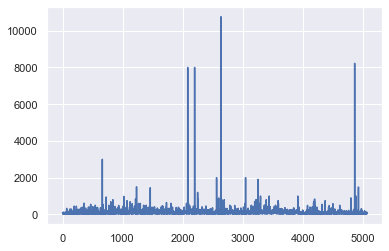

In [7]:
df_list.price.plot();

Looks like there are some outliers which might bias the means. 

### What is the distribution on prices:

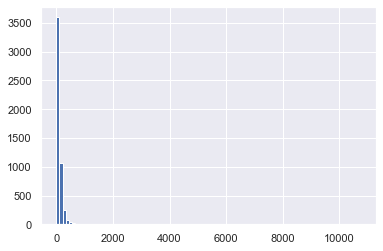

In [8]:
df_list.price.hist(bins=100);

#### Zoom in to 0-800

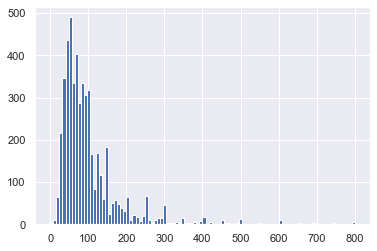

In [9]:
df_list[df_list.price <= 800].price.hist(bins=100);

### Prices above $500 are outliers, let's remove them before starting the analysis

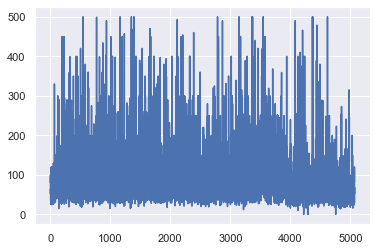

In [10]:
df_list = df_list[df_list.price<=500]
df_list.price.plot();

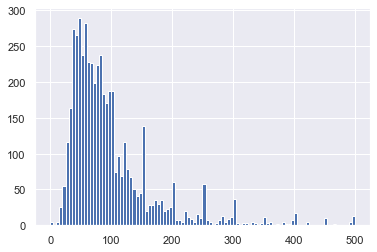

In [11]:
df_list.price.hist(bins=100);

Looks much better now. Still some space for improvements, especially for linear regression. 

___

### Checking missing values and outliers in the ratings:

Before we start, let's check NULL values

In [12]:
str(round(len(df_list[df_list.review_scores_rating.isnull()])/df_list.shape[0]*100, ndigits=2)) + ' %'

'26.21 %'

If we want to work with review scores rating, we need to fill all NULL values in there. If we used mean over the whole dataset, it will average ratings of all districts together. To make it more precise, I'll replace the NULL values by the mean of listings **in the same district** (neighbourhood_cleansed).

Calculate average rating of listings per district (neighbourhood_cleansed) and add it as new column to the listings:

In [13]:
avg_ratings = df_list[['neighbourhood_cleansed', 'review_scores_rating']].groupby(by='neighbourhood_cleansed').mean().reset_index()
avg_ratings = avg_ratings.rename(columns={"review_scores_rating": "avg_district_rating", "neighbourhood_cleansed":"district"})
df_list = pd.merge(df_list, avg_ratings, how='inner', left_on='neighbourhood_cleansed', right_on='district').drop(columns=['district'])

Fill NaN using the average location rating value:

In [14]:
df_list.review_scores_rating = df_list.review_scores_rating.fillna(value=df_list.avg_district_rating)

Check NULL values again:

In [15]:
str(round(len(df_list[df_list.review_scores_rating.isnull()])/df_list.shape[0]*100, ndigits=2)) + ' %'

'0.0 %'

Looks much better now.

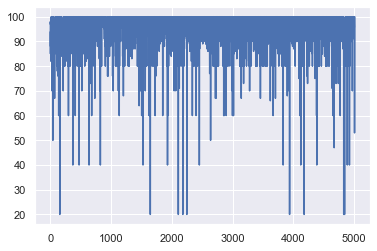

In [16]:
df_list.review_scores_rating.plot();

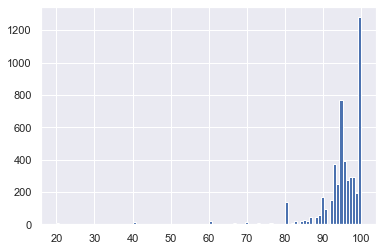

In [17]:
df_list.review_scores_rating.hist(bins=100);

#### It looks like all ratings below 80 are outlier. 
#### They should be removed before we start to calculate average rating per district to not to negatively bias the whole district!

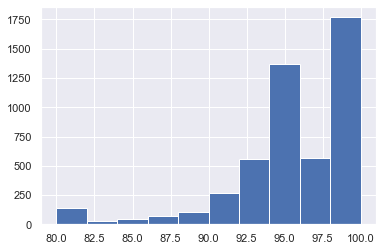

In [18]:
df_list = df_list[df_list.review_scores_rating>=80]
df_list.review_scores_rating.hist();

Looks better now!

-----

## Let's have a look at prices per district:

### Calculate average price for each district (neighbourhood_cleansed)

In [19]:
## create a new DataFrame to store average prices per ditrict
avg_prices = df_list[['neighbourhood_cleansed', 'price']].groupby(by='neighbourhood_cleansed').mean().reset_index()
avg_prices = avg_prices.rename(columns={"neighbourhood_cleansed":"district", "price": "avg_district_price"})

In [20]:
avg_prices

,district,avg_district_price
0,Allach-Untermenzing,88.136364
1,Altstadt-Lehel,133.421348
2,Au-Haidhausen,96.144737
3,Aubing-Lochhausen-Langwied,83.717949
4,Berg am Laim,89.730000
5,Bogenhausen,90.262500
6,Feldmoching-Hasenbergl,70.645161
7,Hadern,79.368421
8,Laim,92.198582
9,Ludwigsvorstadt-Isarvorstadt,125.919325


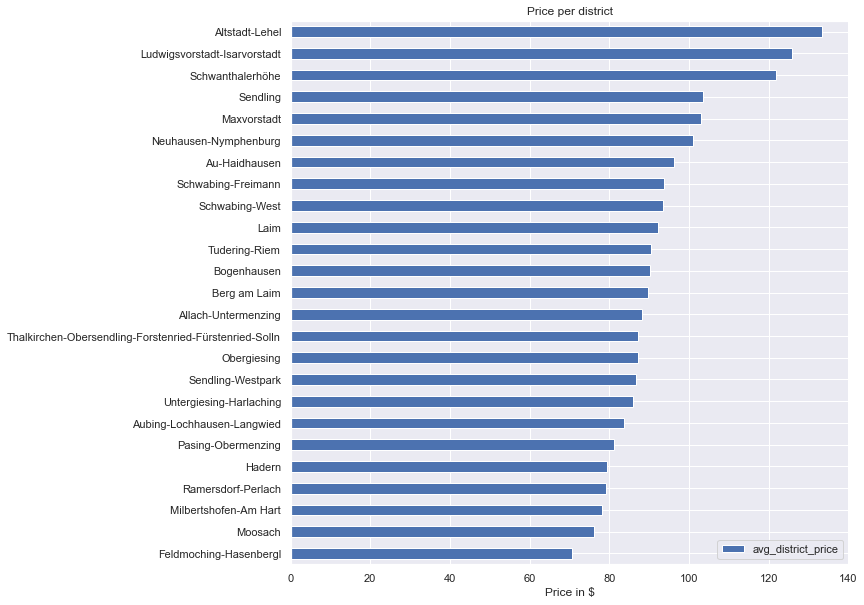

In [21]:
avg_prices.sort_values(by='avg_district_price', ascending=True).plot.barh(x='district', y='avg_district_price', figsize=(10,10));
ax = plt.gca()
ax.set_title('Price per district');
ax.set_ylabel('')
ax.set_xlabel('Price in $');

#### Here we are! This are the **three most expensive** districts in Munich:

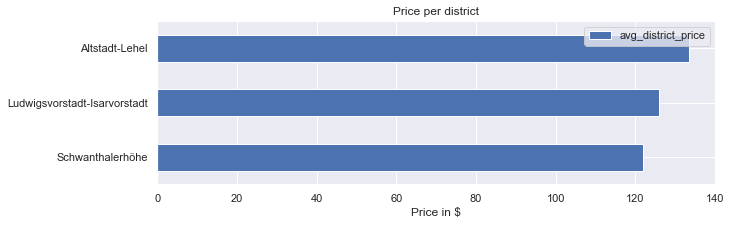

In [22]:
avg_prices.sort_values(by='avg_district_price', ascending=True)[-3:].plot.barh(x='district', y='avg_district_price', figsize=(10,3));
ax = plt.gca()
ax.set_title('Price per district');
ax.set_ylabel('')
ax.set_xlabel('Price in $');

### Ploting geographical distribution of prices per city location:

In [23]:
df_list = pd.merge(df_list, avg_prices, how='inner', left_on='neighbourhood_cleansed', right_on='district').drop(columns='district')

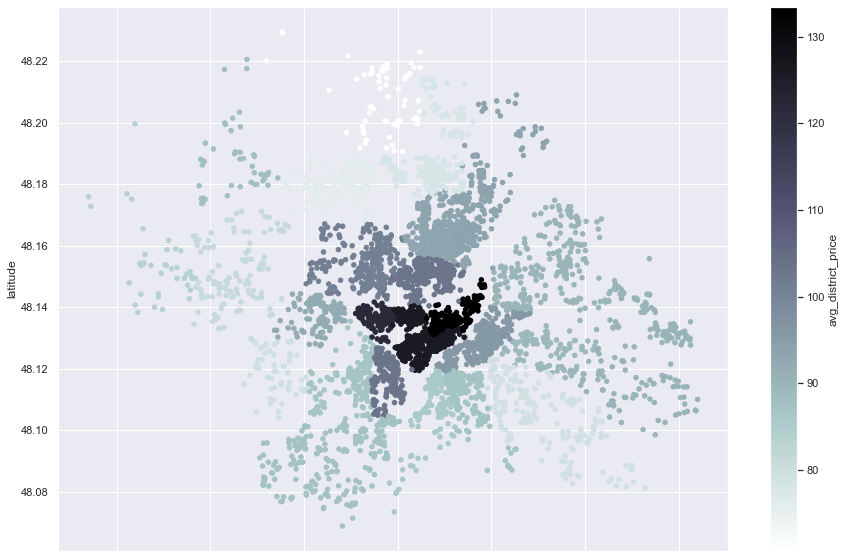

In [24]:
df_list.plot(kind='scatter', x='longitude', y='latitude', alpha=1, c='avg_district_price', figsize=(15,10), cmap=plt.get_cmap('bone_r'));

#### As you can see, the most expensive districts are located in the centre of the city. 
#### But...are the most expensive listing really the best ones? Let's have a look at reviews to see, listings of what district are the best rated ones.

---

## Comparing prices and ratings
### Ploting geographical distribution of ratings per city district:

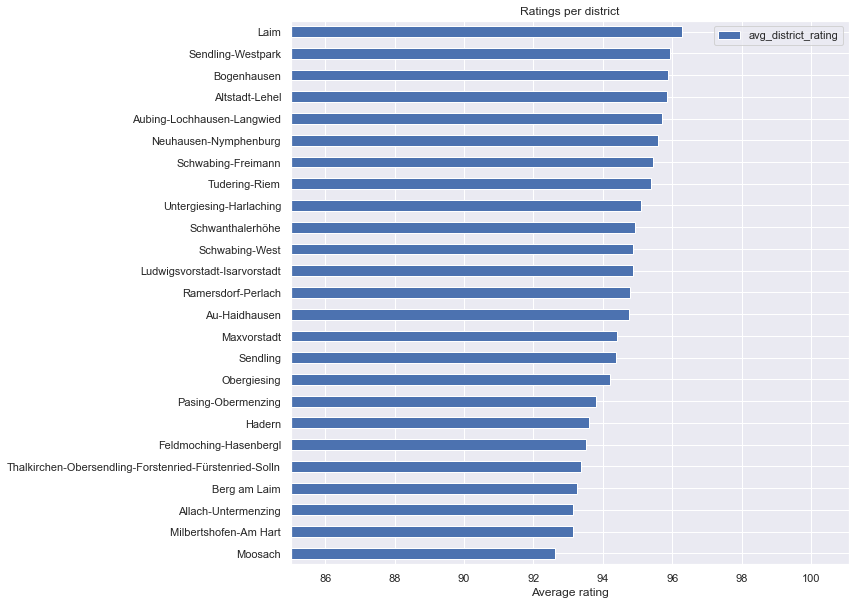

In [25]:
avg_ratings.sort_values(by='avg_district_rating', ascending=True).plot.barh(x='district', y='avg_district_rating', figsize=(10,10));
ax = plt.gca()
ax.set_title('Ratings per district');
ax.set_ylabel('')
ax.set_xlabel('Average rating');
ax.set_xlim(left=85);

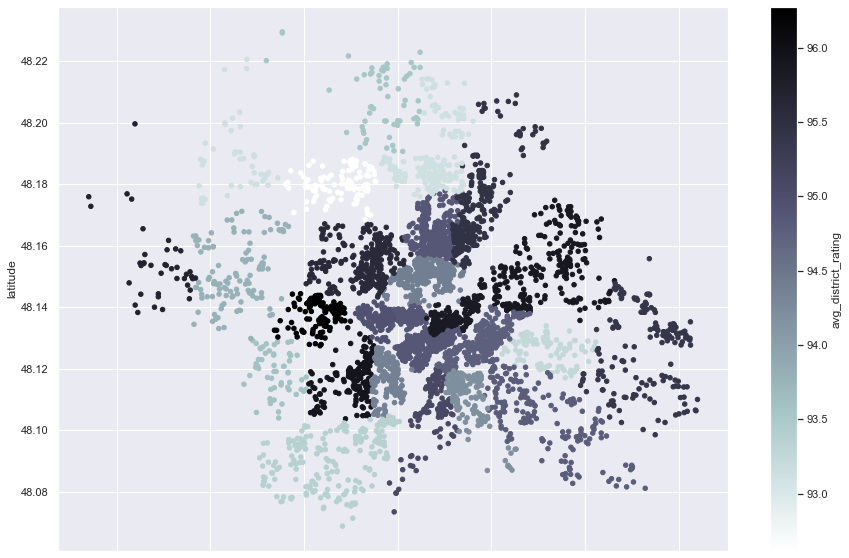

In [26]:
df_list.plot(kind='scatter', x='longitude', y='latitude', alpha=1, c='avg_district_rating', figsize=(15,10), cmap=plt.get_cmap('bone_r'));

#### And here we are. The best rated districts are around but not too far from centre. Locations in the middle of the city are the most expensive which can have negative impact on ratings.

#### **If you want to save some money but still have good rated property, you better book one close to the centre but not directly in the middle of the city.**

---

#### One side question as a matter of interest:
## Are best rated accomodations the ones which are booked out (the least available)?
### Ploting geographical distribution of availabillity (365) per city district:

In [27]:
avg_avail_365 = df_list[['neighbourhood_cleansed', 'availability_365']].groupby(by='neighbourhood_cleansed').mean().reset_index()
avg_avail_365 = avg_avail_365.rename(columns={"neighbourhood_cleansed":"district", "availability_365": "avg_district_avail_365"})
df_list = pd.merge(df_list, avg_avail_365, how='inner', left_on='neighbourhood_cleansed', right_on='district').drop(columns='district')

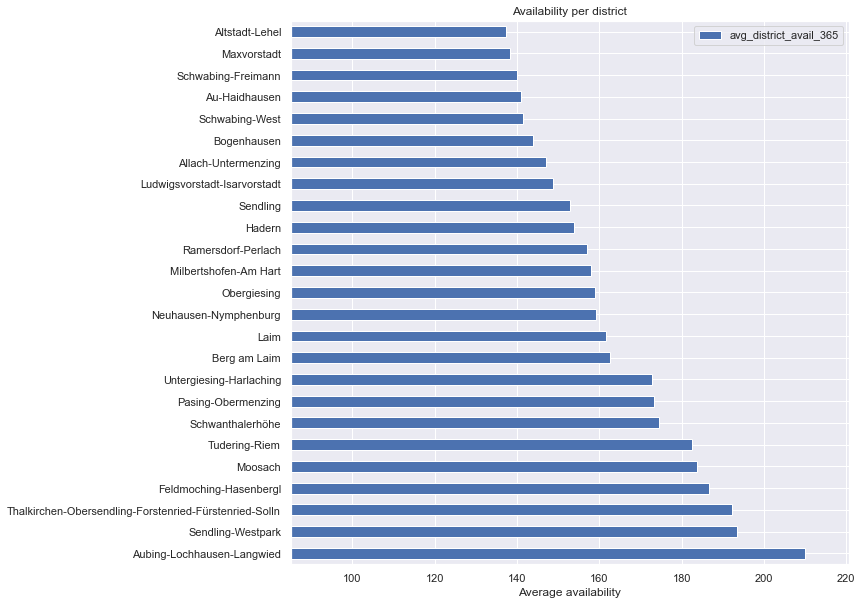

In [28]:
avg_avail_365.sort_values(by='avg_district_avail_365', ascending=False).plot.barh(x='district', y='avg_district_avail_365', figsize=(10,10));
ax = plt.gca()
ax.set_title('Availability per district');
ax.set_ylabel('')
ax.set_xlabel('Average availability');
ax.set_xlim(left=85);

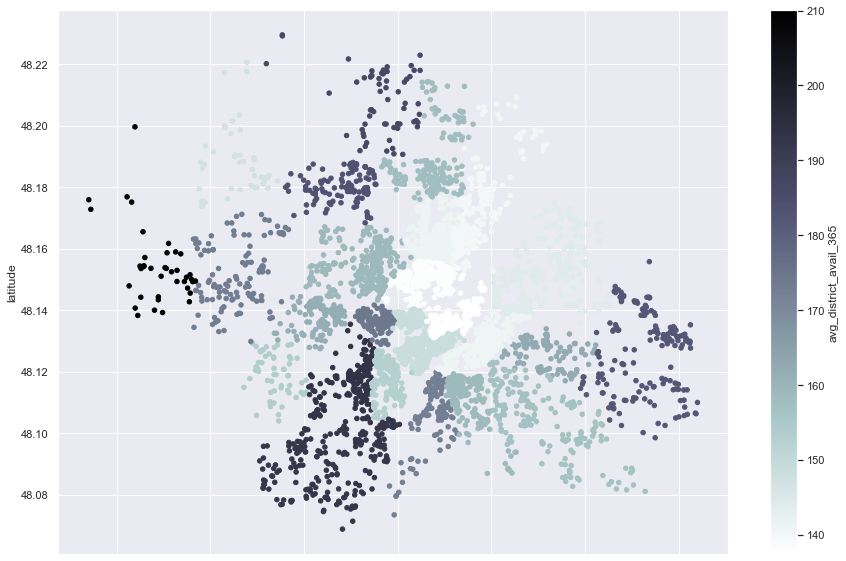

In [29]:
df_list.plot(kind='scatter', x='longitude', y='latitude', alpha=1, c='avg_district_avail_365', figsize=(15,10), cmap=plt.get_cmap('bone_r'));

#### Locations with lower rating have higher availability (over the year). Especialy is this visible on the vertical axe through the centre of the city (south --> mid --> north). This might be showing a tendence where guests pick there accomodation based on the ratings.

But...there are some exceptions: Sendling-Westpark ist good rated location but still having a lot of available accomodations.

___

# **!!! IMPORTANT REMARK !!!**
## The whole availability data might be biased due to the Covid-19 lockdown. The listings might not really be listed as available, even if not booked. This analysis needs to be re-run after the pandemic to get more precise results.

---------------------------

## We have found good districts to book. Let's see what property type is reasonable regarding the cost.
### Let's check property types before answering the question

In [30]:
# Remove all prices which are 0
len(df_list[df_list.price==0])

4

In [31]:
df_list = df_list[df_list.price>0].copy()

___

### Let's focus to most common property types (top 20 in ranking of common property types)

In [32]:
df_list.property_type.value_counts()[:20]

Entire apartment                      2372
Private room in apartment             1469
Private room in house                  178
Room in hotel                          127
Entire serviced apartment              127
Entire condominium                      85
Entire loft                             76
Shared room in apartment                60
Room in boutique hotel                  54
Private room in condominium             48
Private room in townhouse               48
Private room in serviced apartment      39
Entire house                            35
Private room in hostel                  27
Room in serviced apartment              19
Private room in loft                    15
Private room in bed and breakfast       14
Room in aparthotel                      13
Entire townhouse                        10
Entire guest suite                      10
Name: property_type, dtype: int64

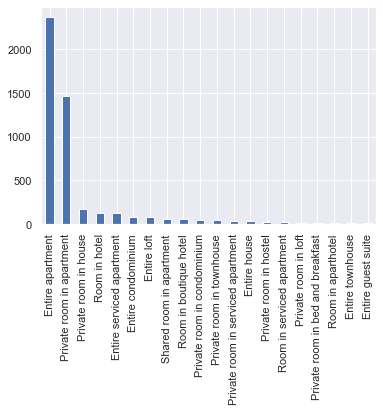

In [33]:
df_list.property_type.value_counts()[:20].plot(kind='bar');

#### Plot prices for top 20 common property types

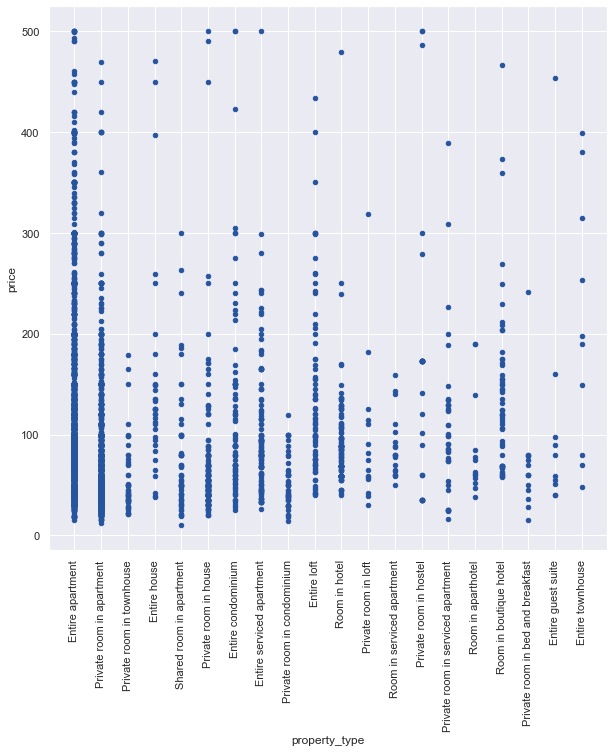

In [34]:
# based of values_counts, pick top 20 common property types and plot prices of each of them
lst_top20 = list(df_list.property_type.value_counts()[:20].index)
df_list_top_20 = df_list[df_list.property_type.isin(lst_top20)].copy()
df_list_top_20.plot(kind='scatter', x='property_type', y='price', rot=90,  figsize=(10,10), c='#26549e');

#### Ok, this doesn't provide much value. You can find each property type with huge variance in price. 

#### Instead of this, let's compare average of each property type to the average price. Not to bias this comparision due to better/worse district, we compare the price to the average price of all property types **in the same district**. This can releave reasonable property types which are not too expensive compared to others.

---

### First, let's calculate the diff between each listing and the average price of the district this listing is in. Let's calculate absolute and relative difference (%).

In [35]:
df_list_top_20['avg_price_diff'] = df_list_top_20.price - df_list_top_20.avg_district_price
df_list_top_20['avg_price_diff_perc'] = np.round(100*((df_list_top_20.price-df_list_top_20.avg_district_price)/df_list_top_20.price), decimals=2)
df_list_top_20[['property_type','price', 'avg_district_price', 'avg_price_diff', 'avg_price_diff_perc']]

,property_type,price,avg_district_price,avg_price_diff,avg_price_diff_perc
0,Entire apartment,80.0,79.368421,0.631579,0.79
1,Private room in apartment,46.0,79.368421,-33.368421,-72.54
2,Entire apartment,80.0,79.368421,0.631579,0.79
3,Private room in townhouse,99.0,79.368421,19.631579,19.83
4,Entire house,39.0,79.368421,-40.368421,-103.51
...,...,...,...,...,...
4906,Private room in house,23.0,83.717949,-60.717949,-263.99
4907,Private room in condominium,50.0,83.717949,-33.717949,-67.44
4908,Private room in serviced a...,45.0,83.717949,-38.717949,-86.04
4909,Private room in house,20.0,83.717949,-63.717949,-318.59


### Now, let's group all listings by property type and calculate the average diff per property:

In [36]:
avg_prices_loc_prop = np.round(df_list_top_20[['property_type', 'avg_price_diff_perc']].groupby(by=['property_type']).mean(), decimals=2).reset_index()
sorted_top20 = avg_prices_loc_prop.sort_values(by='avg_price_diff_perc', ascending=False).set_index('property_type')

In [37]:
sorted_top20.style.bar(subset=['avg_price_diff_perc'], align='mid', color=['#fcc9b8', '#86eba0'], width=100)

,avg_price_diff_perc
property_type,
Entire townhouse,34.760000
Entire house,18.040000
Room in boutique hotel,4.050000
Entire loft,2.650000
Room in serviced apartment,-6.730000
Private room in hostel,-17.540000
Entire condominium,-18.330000
Entire apartment,-22.240000
Room in hotel,-30.500000


### Here we are: We see that compared to all prices in the same district, the entire townhouse or house are the most expensive property types to book. On the other hand, a provate room in a condo is something you might have a look at if you want to save your budget.

---

# Summary:

### If you want to get a reasonable accomodation in Munich based on rating and price, try to pick something around the centre of the city. You will not pay too much and will get best rated accomodations.
### To optimize your costs, a private room in a condo or in a townhouse might be a good choice. (If money is not your problem, a house or a townhouse is an alternative).